In [1]:
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
    with_info=True)

In [2]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\Dawid\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [3]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

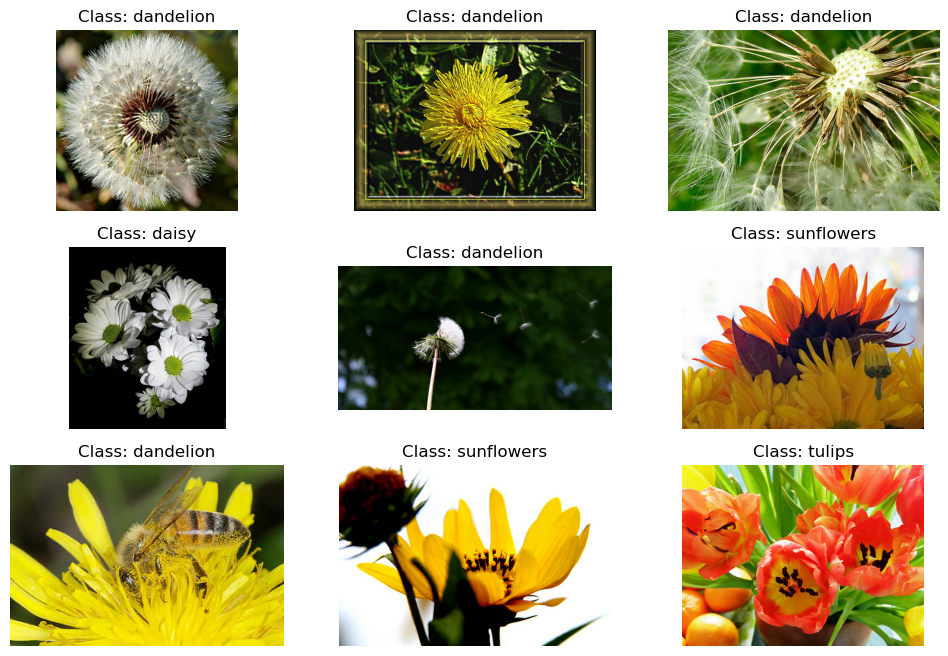

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show(block=False)

In [5]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [6]:
import tensorflow as tf
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


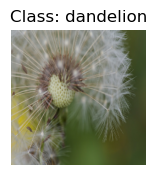

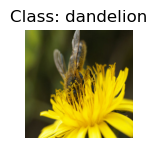

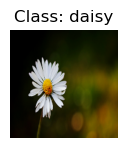

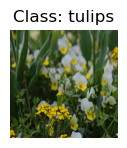

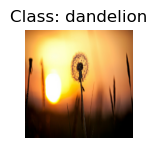

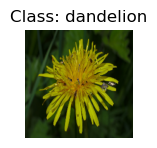

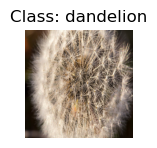

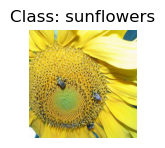

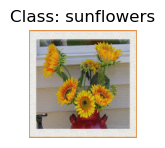

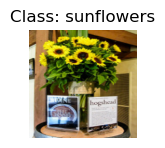

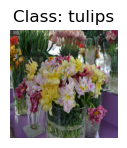

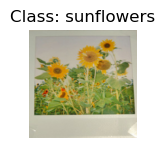

In [7]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
        plt.show()

In [8]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Rescaling,Dense,Resizing
from keras.models import Sequential

In [9]:
model = keras.models.Sequential([
    Rescaling(1/255),
    Conv2D(filters=32, kernel_size=3),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=2,
        activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=2,
        activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=16, activation='relu'),
    Dropout(0.5),
    Dense(units=5, activation='softmax')
    ])

In [10]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set,
    epochs=10)

Epoch 1/10
86/86 [==============================] - 64s 717ms/step - loss: 1.6039 - accuracy: 0.2475 - val_loss: 1.4466 - val_accuracy: 0.2486
Epoch 2/10
86/86 [==============================] - 65s 666ms/step - loss: 1.5009 - accuracy: 0.3023 - val_loss: 1.4062 - val_accuracy: 0.4029
Epoch 3/10
86/86 [==============================] - 65s 700ms/step - loss: 1.3898 - accuracy: 0.3245 - val_loss: 1.2228 - val_accuracy: 0.4973
Epoch 4/10
86/86 [==============================] - 72s 718ms/step - loss: 1.3196 - accuracy: 0.3903 - val_loss: 1.1992 - val_accuracy: 0.5572
Epoch 5/10
86/86 [==============================] - 66s 689ms/step - loss: 1.2492 - accuracy: 0.4201 - val_loss: 1.0842 - val_accuracy: 0.5426
Epoch 6/10
86/86 [==============================] - 63s 683ms/step - loss: 1.2312 - accuracy: 0.4281 - val_loss: 1.1073 - val_accuracy: 0.5554
Epoch 7/10
86/86 [==============================] - 64s 668ms/step - loss: 1.1700 - accuracy: 0.4626 - val_loss: 1.0777 - val_accuracy: 0.5880

In [11]:
results_test = model.evaluate(test_set, batch_size=128)
print(results_test)
results_valid = model.evaluate(valid_set, batch_size=128)
print(results_valid)
results_train = model.evaluate(train_set, batch_size=128)
print(results_train)

12/12 [==============================] - 2s 142ms/step - loss: 0.9329 - accuracy: 0.6540
[0.9328945875167847, 0.6539509296417236]
18/18 [==============================] - 2s 133ms/step - loss: 0.9453 - accuracy: 0.6098
[0.9452579021453857, 0.6098003387451172]
86/86 [==============================] - 14s 133ms/step - loss: 0.6598 - accuracy: 0.7703
[0.6597926020622253, 0.770348846912384]


In [12]:
import pickle

with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump((results_train[1], results_valid[1], results_test[1]), f)

In [13]:
def preprocess2(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.map(preprocess2).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess2).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess2).batch(batch_size).prefetch(1)

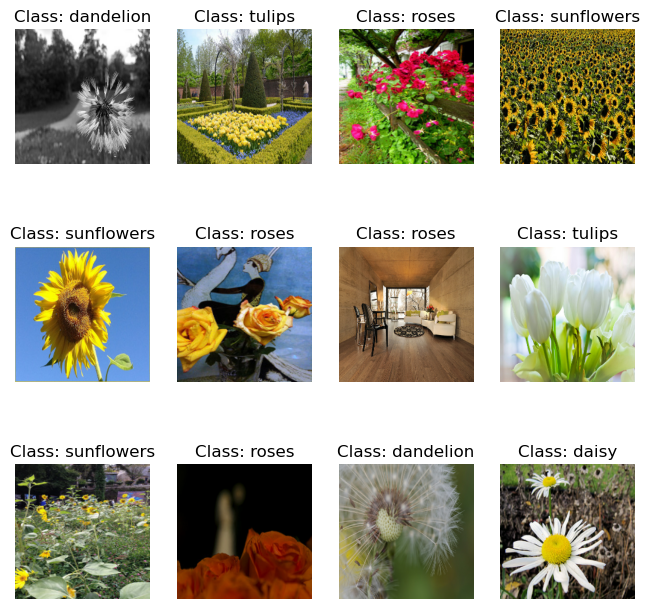

In [14]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [ ]:
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

In [ ]:
tf.keras.utils.plot_model(base_model)

In [ ]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dd = keras.layers.Dense(512, activation="relu")(avg)
do = keras.layers.Dropout(0.4)(dd)
dd1 = keras.layers.Dense(255, activation="relu")(do)
do1 = keras.layers.Dropout(0.4)(dd1)
dd2 = keras.layers.Dense(128, activation="relu")(do1)
do2 = keras.layers.Dropout(0.4)(dd2)
output = keras.layers.Dense(5, activation="softmax")(do2)
model2 = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model2.compile(loss="sparse_categorical_crossentropy",
    optimizer="adam", metrics=["accuracy"])
history = model2.fit(train_set, validation_data=valid_set,
    epochs=5)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
model2.compile(loss="sparse_categorical_crossentropy",
    optimizer="adam", metrics=["accuracy"])
history = model2.fit(train_set,
    validation_data=valid_set,
    epochs=2)

In [ ]:
results_test2 = model2.evaluate(test_set, batch_size=128)
print(results_test)
results_valid2 = model2.evaluate(valid_set, batch_size=128)
print(results_valid)
results_train2 = model2.evaluate(train_set, batch_size=128)
print(results_train)

In [ ]:
with open('xception_acc.pkl', 'wb') as f:
    pickle.dump((results_train2[1], results_valid2[1], results_test2[1]), f)